In [ ]:
import os
from google.colab import drive
# Run this
drive.mount('/content/drive/')
dataset_path = '/content/drive/MyDrive/DataFiles/'
os.chdir(dataset_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install pretty_midi mido

import pretty_midi
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from mido import KeySignatureError
import os
import random
import tensorflow as tf

# Data Loading and Preprocessing

def load_midi_features(directory):
    """Loads MIDI files and extracts pitch, duration, and velocity features."""
    pitch_sequences = []
    duration_sequences = []
    velocity_sequences = []

    for filename in os.listdir(directory):
        if filename.endswith(".mid"):
            midi_path = os.path.join(directory, filename)
            try:
                midi = pretty_midi.PrettyMIDI(midi_path)
                for instrument in midi.instruments:
                    pitches = [note.pitch for note in instrument.notes]
                    durations = [note.end - note.start for note in instrument.notes]
                    velocities = [note.velocity for note in instrument.notes]
                    pitch_sequences.append(pitches)
                    duration_sequences.append(durations)
                    velocity_sequences.append(velocities)
            except KeySignatureError as e:
                print(f"Skipping file {filename} due to KeySignatureError: {e}")

    return pitch_sequences, duration_sequences, velocity_sequences

# Load features for each composer
bach_pitches, bach_durations, bach_velocities = load_midi_features("/content/drive/MyDrive/DataFiles/Bach/")
mozart_pitches, mozart_durations, mozart_velocities = load_midi_features("/content/drive/MyDrive/DataFiles/Mozart/")
beethoven_pitches, beethoven_durations, beethoven_velocities = load_midi_features("/content/drive/MyDrive/DataFiles/Beethoven/")
chopin_pitches, chopin_durations, chopin_velocities = load_midi_features("/content/drive/MyDrive/DataFiles/Chopin/")

def normalize_features(pitch_sequences, duration_sequences, velocity_sequences):
    """Normalizes pitches, durations, and velocities to a 0-1 range."""
    normalized_pitches = [[note / 127.0 for note in sequence] for sequence in pitch_sequences]
    max_duration = max([max(durations) for durations in duration_sequences if durations])  # Find max duration
    normalized_durations = [[duration / max_duration for duration in sequence] for sequence in duration_sequences]
    normalized_velocities = [[velocity / 127.0 for velocity in sequence] for sequence in velocity_sequences]

    return normalized_pitches, normalized_durations, normalized_velocities

# Normalize the features
bach_pitches, bach_durations, bach_velocities = normalize_features(bach_pitches, bach_durations, bach_velocities)
mozart_pitches, mozart_durations, mozart_velocities = normalize_features(mozart_pitches, mozart_durations, mozart_velocities)
beethoven_pitches, beethoven_durations, beethoven_velocities = normalize_features(beethoven_pitches, beethoven_durations, beethoven_velocities)
chopin_pitches, chopin_durations, chopin_velocities = normalize_features(chopin_pitches, chopin_durations, chopin_velocities)


# Data Augmentation

def augment_sequence(sequence, num_augmentations=2):
    """Augments a note sequence by transposing and creating variations."""
    augmented_sequences = [sequence]
    for _ in range(num_augmentations):
        transpose_amount = random.randint(-5, 5)  # Transpose by up to 5 semitones
        augmented_sequence = [[note[0] + transpose_amount, note[1], note[2]] for note in sequence] # Transpose only the pitch value (index 0)
        augmented_sequences.append(augmented_sequence)
    return augmented_sequences

def combine_features(pitch_sequences, duration_sequences, velocity_sequences):
    """Combines pitch, duration, and velocity features into a single array."""
    combined_features = []
    for pitches, durations, velocities in zip(pitch_sequences, duration_sequences, velocity_sequences):
        sequence_length = min(len(pitches), len(durations), len(velocities))
        combined_sequence = []
        for i in range(sequence_length):
            combined_sequence.append([pitches[i], durations[i], velocities[i]])
        combined_features.append(combined_sequence)
    return combined_features

# Combine features for each composer
combined_bach = combine_features(bach_pitches, bach_durations, bach_velocities)
combined_mozart = combine_features(mozart_pitches, mozart_durations, mozart_velocities)
combined_beethoven = combine_features(beethoven_pitches, beethoven_durations, beethoven_velocities)
combined_chopin = combine_features(chopin_pitches, chopin_durations, chopin_velocities)

# Augment combined data
augmented_combined_bach = [seq for orig_seq in combined_bach for seq in augment_sequence(orig_seq)]
augmented_combined_mozart = [seq for orig_seq in combined_mozart for seq in augment_sequence(orig_seq)]
augmented_combined_beethoven = [seq for orig_seq in combined_beethoven for seq in augment_sequence(orig_seq)]
augmented_combined_chopin = [seq for orig_seq in combined_chopin for seq in augment_sequence(orig_seq)]

def augment_with_noise(sequence, noise_factor=0.01):
    """Adds noise to the sequence to create variation."""
    noisy_sequence = []
    for note in sequence:
        noisy_note = [
            note[0] + random.uniform(-noise_factor, noise_factor),
            note[1] + random.uniform(-noise_factor, noise_factor),
            note[2] + random.uniform(-noise_factor, noise_factor)
        ]
        noisy_sequence.append(noisy_note)
    return noisy_sequence

def augment_with_tempo(sequence, tempo_factor_range=(0.9, 1.1)):
    """Scales the tempo of the sequence."""
    tempo_factor = random.uniform(*tempo_factor_range)
    tempo_scaled_sequence = [[note[0], note[1] * tempo_factor, note[2]] for note in sequence]
    return tempo_scaled_sequence

# Augment with noise and tempo scaling
augmented_combined_bach.extend([augment_with_noise(seq) for seq in augmented_combined_bach])
augmented_combined_bach.extend([augment_with_tempo(seq) for seq in augmented_combined_bach])

augmented_combined_mozart.extend([augment_with_noise(seq) for seq in augmented_combined_mozart])
augmented_combined_mozart.extend([augment_with_tempo(seq) for seq in augmented_combined_mozart])

augmented_combined_beethoven.extend([augment_with_noise(seq) for seq in augmented_combined_beethoven])
augmented_combined_beethoven.extend([augment_with_tempo(seq) for seq in augmented_combined_beethoven])

augmented_combined_chopin.extend([augment_with_noise(seq) for seq in augmented_combined_chopin])
augmented_combined_chopin.extend([augment_with_tempo(seq) for seq in augmented_combined_chopin])

import numpy as np

def create_windows(sequence, window_size, step_size=1):
    """Splits a sequence into overlapping windows."""
    windows = []
    for start in range(0, len(sequence) - window_size + 1, step_size):
        end = start + window_size
        window = sequence[start:end]
        windows.append(window)
    return windows


# Apply windowing to all sequences
window_size = 50
step_size = 20

# Function to apply windowing to an entire dataset
def apply_windowing(sequences, window_size, step_size=1):
    windowed_sequences = []
    for sequence in sequences:
        windows = create_windows(sequence, window_size, step_size)
        windowed_sequences.extend(windows)  # Add all windows of a sequence
    return windowed_sequences

# Apply windowing to each composer's dataset
windowed_bach = apply_windowing(augmented_combined_bach, window_size, step_size)
windowed_mozart = apply_windowing(augmented_combined_mozart, window_size, step_size)
windowed_beethoven = apply_windowing(augmented_combined_beethoven, window_size, step_size)
windowed_chopin = apply_windowing(augmented_combined_chopin, window_size, step_size)

# Combine windowed data
all_windowed_data = windowed_bach + windowed_mozart + windowed_beethoven + windowed_chopin

# Update labels for each windowed sequence
windowed_labels = [0] * len(windowed_bach) + [1] * len(windowed_mozart) + \
                  [2] * len(windowed_beethoven) + [3] * len(windowed_chopin)

# Flatten windowed data to extract unique pitches
flattened_data = [note[0] for sequence in all_windowed_data for note in sequence]

# Tokenize the note pitches
all_pitches = sorted(set(flattened_data))
note_to_int = {note: number for number, note in enumerate(all_pitches)}

# Formatting for model input
tokenized_data = [[note_to_int[note[0]] for note in sequence] for sequence in all_windowed_data]
X = pad_sequences(tokenized_data, maxlen=window_size, padding='post')

# One-hot encode the composers labels
labels = to_categorical(windowed_labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Skipping file Anhang 14-3.mid due to KeySignatureError: Could not decode key with 3 flats and mode 255


In [ ]:
# LSTM model with 10 epochs
from tensorflow.keras.callbacks import ModelCheckpoint


# Define LSTM model
model_windowed = Sequential()
model_windowed.add(Embedding(len(all_pitches), 128, input_length=window_size))
model_windowed.add(LSTM(256, return_sequences=True))
model_windowed.add(Dropout(0.3))
model_windowed.add(LSTM(128))
model_windowed.add(Dropout(0.3))
model_windowed.add(Dense(64, activation='relu'))
model_windowed.add(Dense(4, activation='softmax'))


model_windowed.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Formatting train and test datasets for the model
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(512).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(512).prefetch(tf.data.AUTOTUNE)

# Save the model frequently
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/windowed_model.keras',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Train the model using the dataset
model_windowed.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=[early_stopping])

model_windowed.save('/content/drive/MyDrive/windowed_model_final.keras')
%cd /content/drive/MyDrive/
model_windowed.save('final_model.keras')

# Evaluate the model
loss, accuracy = model_windowed.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 638397184 elements. This may consume a large amount of memory.
  warnings.warn(


1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5481s 4s/step - accuracy: 0.6202 - loss: 0.8733 - val_accuracy: 0.8040 - val_loss: 0.4629
Epoch 2/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5431s 4s/step - accuracy: 0.8224 - loss: 0.4261 - val_accuracy: 0.8529 - val_loss: 0.3616
Epoch 3/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5658s 4s/step - accuracy: 0.8665 - loss: 0.3309 - val_accuracy: 0.9049 - val_loss: 0.2471
Epoch 4/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5461s 4s/step - accuracy: 0.9193 - loss: 0.2124 - val_accuracy: 0.9430 - val_loss: 0.1567
Epoch 5/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5309s 4s/step - accuracy: 0.9567 - loss: 0.1211 - val_accuracy: 0.9669 - val_loss: 0.0966
Epoch 6/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5378s 4s/step - accuracy: 0.9736 - loss: 0.0766 - val_accuracy: 0.9774 - val_loss: 0.0674
Epoch 7/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5260s 4s/step - accuracy: 0.9836 - loss: 0.0475 - val_accuracy: 0.9841 - val_loss: 0.0489
Epoch 8/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 5269s 4s/step - accuracy: 0.9877 - loss: 0.03

In [ ]:
# Simplified LSTM model for quicker runtime
model_windowed = Sequential()
model_windowed.add(Embedding(len(all_pitches), 128, input_length=window_size))
model_windowed.add(LSTM(256, return_sequences=True))
model_windowed.add(Dropout(0.3))
model_windowed.add(LSTM(128))
model_windowed.add(Dropout(0.3))
model_windowed.add(Dense(64, activation='relu'))
model_windowed.add(Dense(4, activation='softmax'))

window_size = 50
model_windowed.build((None, window_size))

model_windowed.load_weights('/content/drive/MyDrive/final_model.keras')
model_windowed.layers[0].trainable = False


# Compile the model
model_windowed.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history = model_windowed.fit(train_dataset, epochs=5, validation_data=test_dataset, callbacks=[early_stopping])


Epoch 1/5
751/751 ━━━━━━━━━━━━━━━━━━━━ 802s 1s/step - accuracy: 0.9394 - loss: 0.1645 - val_accuracy: 0.9384 - val_loss: 0.1750
Epoch 2/5
751/751 ━━━━━━━━━━━━━━━━━━━━ 776s 1s/step - accuracy: 0.9497 - loss: 0.1396 - val_accuracy: 0.9437 - val_loss: 0.1637
Epoch 3/5
751/751 ━━━━━━━━━━━━━━━━━━━━ 826s 1s/step - accuracy: 0.9560 - loss: 0.1253 - val_accuracy: 0.9478 - val_loss: 0.1549
Epoch 4/5
751/751 ━━━━━━━━━━━━━━━━━━━━ 852s 1s/step - accuracy: 0.9603 - loss: 0.1143 - val_accuracy: 0.9510 - val_loss: 0.1470
Epoch 5/5
751/751 ━━━━━━━━━━━━━━━━━━━━ 818s 1s/step - accuracy: 0.9642 - loss: 0.1039 - val_accuracy: 0.9544 - val_loss: 0.1402


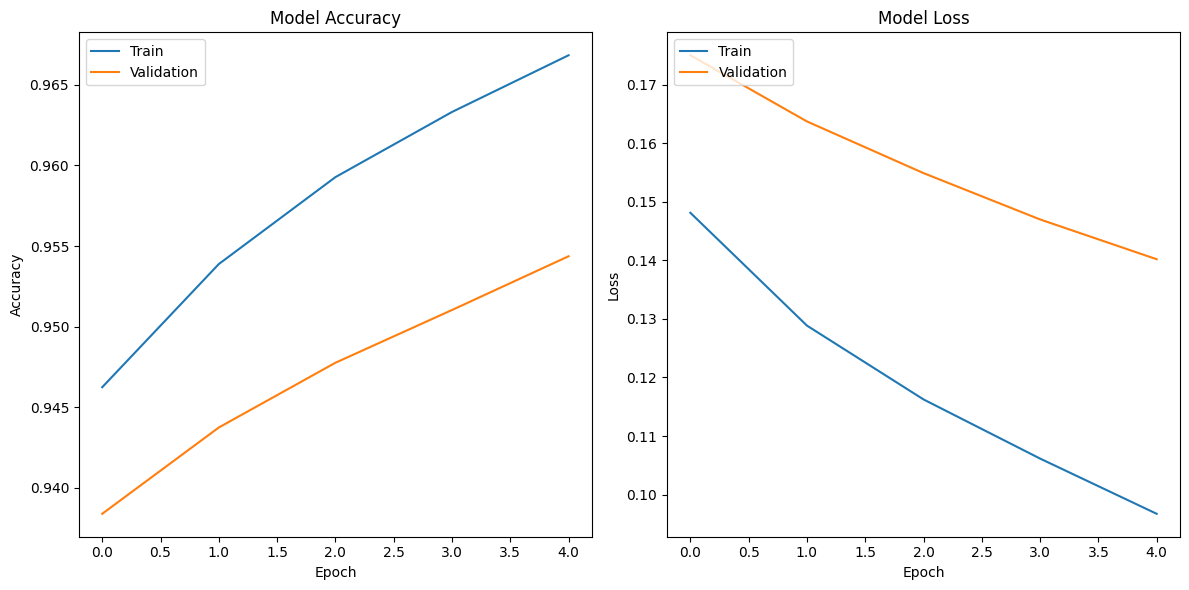

In [ ]:
# Load model from h5 file (if needed)
from tensorflow.keras.models import load_model
# model_windowed = load_model('/content/drive/MyDrive/windowed_model_final.h5')
from matplotlib import pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']



In [ ]:
import pandas as pd
df = pd.DataFrame({
    'loss': training_loss,
    'accuracy': training_accuracy,
    'val_loss': validation_loss,
    'val_accuracy': validation_accuracy
})
df.to_csv('/content/drive/MyDrive/training_history.csv', index=False)

In [ ]:
# Print predicted vs actual for validation data
predictions = model_windowed.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

for i in range(len(X_test)):
    print(f"Actual: {np.argmax(y_test[i])}, Predicted: {predicted_labels[i]}")

Streaming output truncated to the last 5000 lines.
Actual: 3, Predicted: 3
Actual: 1, Predicted: 1
Actual: 2, Predicted: 2
Actual: 0, Predicted: 0
Actual: 3, Predicted: 3
Actual: 0, Predicted: 0
Actual: 2, Predicted: 2
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 2, Predicted: 2
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 2, Predicted: 2
Actual: 2, Predicted: 2
Actual: 0, Predicted: 0
Actual: 2, Predicted: 2
Actual: 3, Predicted: 3
Actual: 2, Predicted: 2
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 3, Predicted: 3
Actual: 0, Predicted: 0
Actual: 3, Predicted: 3
Actual: 2, Predicted: 2
Actual: 3, Predicted: 3
Actual: 3, Predicted: 3
Actual: 2, Predicted: 2
Actual: 0, Predicted: 0
Actual: 3, Predicted: 0
Actual: 2, Predicted: 2
Actual: 0, Predicted: 0
Actual: 3, Predicted: 3
Actual: 3, Predicted: 3
Actual: 2, Predicted: 2
Actual: 2, Predicted: 2
Actual: 0, Pr

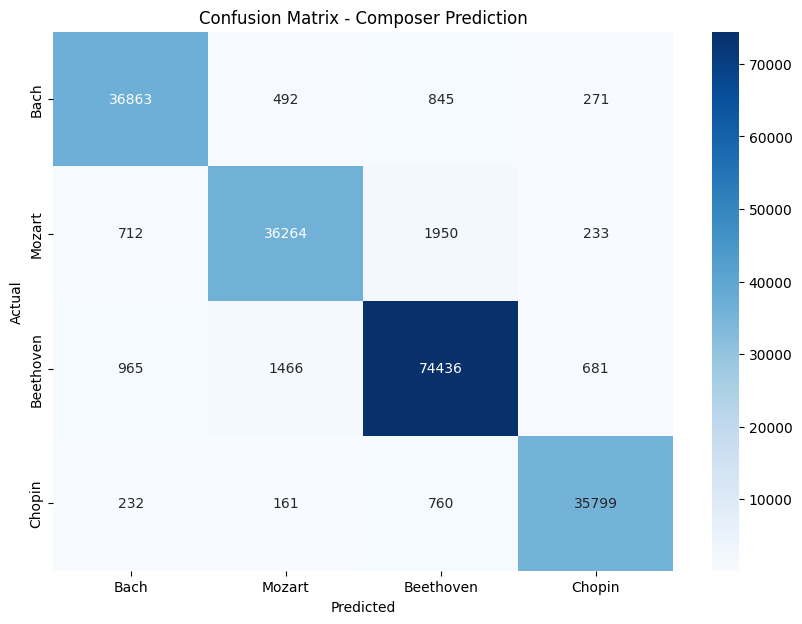

In [ ]:
# Recode numerical labels to composer names (since we used one-hot encoding)
composers = ['Bach', 'Mozart', 'Beethoven', 'Chopin']
y_true = [np.argmax(y_test[i]) for i in range(len(X_test))]
y_pred_names = [composers[pred] for pred in predicted_labels]
y_true_names = [composers[true] for true in y_true]

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_names, y_pred_names, labels=composers)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=composers, yticklabels=composers)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Composer Prediction')
plt.show()